In [1]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import numpy as np
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import pulse
from qiskit.circuit import Parameter

IBMQ.save_account('27777547173d647881e4d6356ef15e23bccdc0f69bb288d5d923d3d1749aa877c04fec5cbf1f0dd7b7a962c3e0b9a0a200d4feef6a3ead3adc924435ca36cb0a')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit = 0
mem_slot = 0
qubit_frequency_ini = backend_defaults.qubit_freq_est[qubit]

configrc.store_credentials:WARNING:2022-04-17 16:40:55,267: Credentials already present. Set overwrite=True to overwrite.


In [2]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

def baseline_remove(values):
    return np.array(values) - np.mean(values)

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit

In [3]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

scale_factor = 1e-14

drive_sigma_sec = 0.075 * us
drive_duration_sec = drive_sigma_sec * 8

# 1. Qubit Spectroscopy

In [4]:
amplitude_min = 0
amplitude_max = 0.8
amplitude_list = np.linspace(amplitude_min, amplitude_max, 30)

In [5]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_frequency_ini, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in amplitude_list]

In [6]:
num_shots_per_point = 1024

# rabi_job = backend.run(rabi_schedules,
#                   meas_level=1,
#                   meas_return='avg',
#                   shots=num_shots_per_point)

rabi_job = backend.retrieve_job('621aced55dfd776d1b5b3b99')

job_monitor(rabi_job)

Job Status: job has successfully run


In [7]:
rabi_results = rabi_job.result(timeout=120)

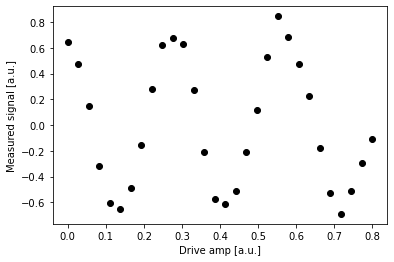

In [8]:
rabi_values = []
for i in range(30):
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(amplitude_list, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [9]:
drive_amps = amplitude_list

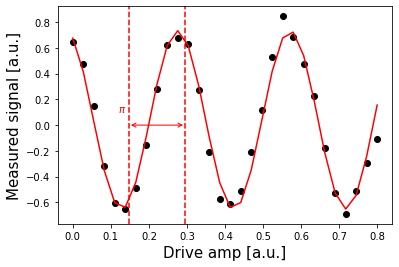

In [10]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values,
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.3, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [11]:
pi_amp = abs(drive_period / 2)

In [12]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [13]:
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [14]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T1 delay Experiment") as t1_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_frequency_ini, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

t1_schedules = [t1_schedule.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

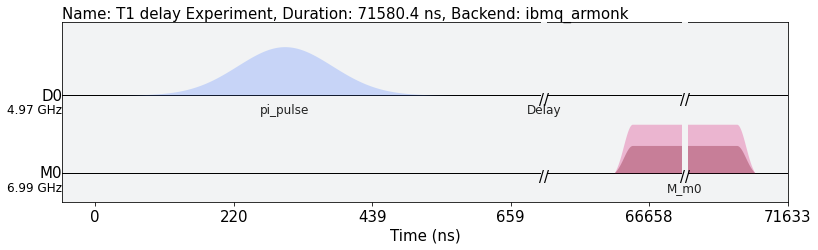

In [15]:
sched_idx = 10
t1_schedules[sched_idx].draw(backend=backend)

In [16]:
num_shots = 256

t1_job = backend.retrieve_job('621ee2f0632ad840a236c2a4')

job_monitor(t1_job)

Job Status: job has successfully run


In [17]:
t1_results = t1_job.result(timeout=120)

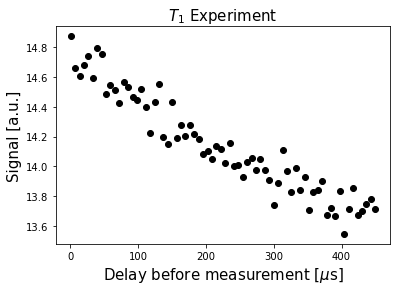

In [18]:
t1_values = []

for i in range(len(t1_results.results)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(-np.real(sum(iq_data) / num_shots))

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

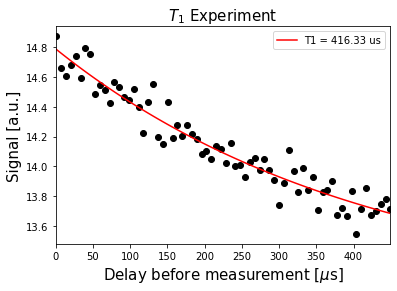

In [19]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values,
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [20]:
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec_t2 = np.arange(2 * us, tau_max_sec, tau_step_sec)

In [21]:
drive_amp = pi_amp / 2

with pulse.build(backend) as pi2_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='pi2_pulse'), drive_chan)

In [22]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_frequency_ini, drive_chan)
    pulse.call(pi2_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi2_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

t2_schedules = [t2_schedule.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec_t2]

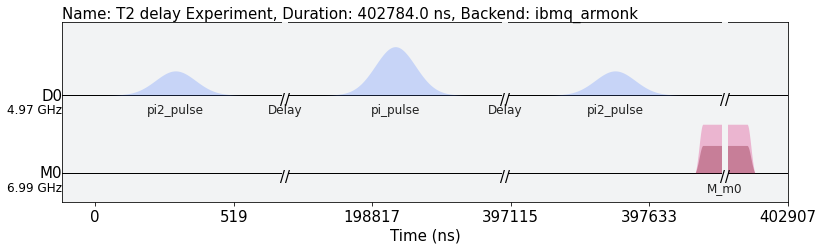

In [23]:
t2_schedules[-1].draw(backend=backend)

In [24]:
# Execution settings
num_shots_per_point = 512

t2_echo_job = backend.retrieve_job('6223d190412e38464b4df0bc')

job_monitor(t2_echo_job)

Job Status: job has successfully run


In [25]:
t2_results = t2_echo_job.result(timeout=120)

C:\Users\user\anaconda3\envs\kseamentoring\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


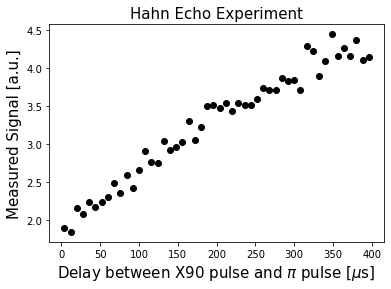

In [26]:
t2_values = []

for i in range(len(delay_times_sec_t2)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(-sum(iq_data) / num_shots_per_point)


plt.scatter(2*delay_times_sec_t2/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

C:\Users\user\anaconda3\envs\kseamentoring\lib\site-packages\numpy\lib\function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


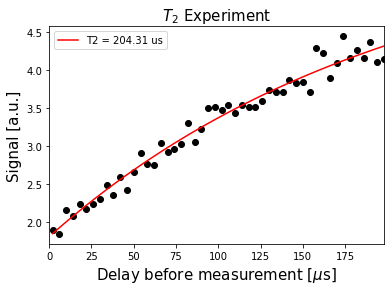

In [27]:
fit_params, y_fit = fit_function(delay_times_sec_t2/us, t2_values,
            lambda x, A, C, T2: (A * np.exp(-x / T2) + C),
            [-3, 3, 100]
            )

_, _, T2 = fit_params

plt.scatter(delay_times_sec_t2/us, t2_values, color='black')
plt.plot(delay_times_sec_t2/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(delay_times_sec_t2/us))
plt.title("$T_2$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()